In this notebook Deep Neural Network is used to remove noise from images. The NN is implemented using TensorFLow and the dataset is obtained from Kaggle.

<a href = "https://www.kaggle.com/c/denoising-dirty-documents">Data Source</a>

In [3]:
#Importing Libraries
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML, Image
plt.style.use('ggplot')

In [7]:
#Saving File names to a list
train = [os.path.join('train', img) for img in os.listdir('train') if img.endswith('.png')]
train_cleaned = [os.path.join('train_cleaned', img) for img in os.listdir('train_cleaned') if img.endswith('.png')]

Given below is an image in the dataset and the same image with noise removed

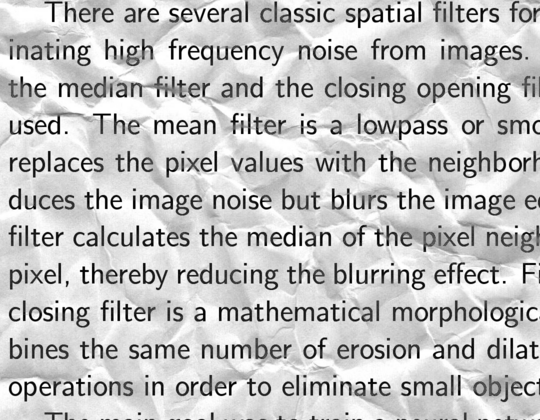

In [8]:
Image(train[0])

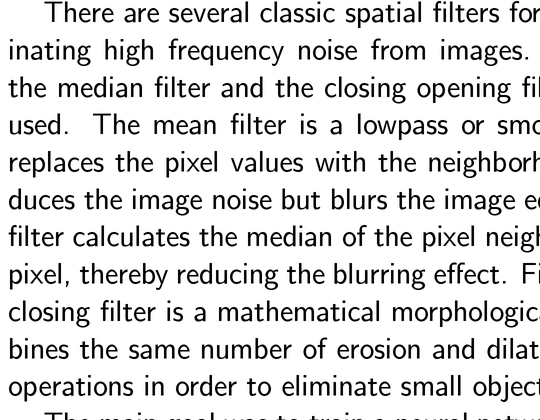

In [12]:
Image(train_cleaned[0])

In [13]:
train_img = [plt.imread(img) for img in train]
train_cleaned_img = [plt.imread(img) for img in train_cleaned]

In [128]:
shapes_train = [img.shape for img in train_img]

In [129]:
print(set(shapes_train))

{(420, 540), (258, 540)}



So there are 2 sets of images, one with <strong>540x420 px</strong> resolution and one with <strong>540x258px</strong> resolution. Here for avoiding lengthy computation time I am only denoising one set of images.

In [25]:
train_420_540 =[]
train_258_540 = []
for img in train_img:
    if img.shape[0] == 420:
        train_420_540.append(img)
    else:
        train_258_540.append(img)
train_420_540_clean =[]
train_258_540_clean = []
for img in train_cleaned_img:
    if img.shape[0] == 420:
        train_420_540_clean.append(img)
    else:
        train_258_540_clean.append(img)

Lets check one of the test images.

In [26]:
test = [os.path.join('test', img) for img in os.listdir('test') if img.endswith('.png')]

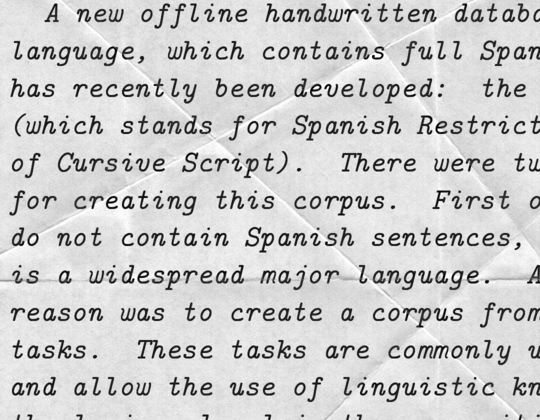

In [28]:
Image(test[1])

In [29]:
test_img = [plt.imread(img) for img in test]

In [127]:
shapes_test = [img.shape for img in test_img]
print(set(shapes_test))

{(420, 540), (258, 540)}


In [31]:
test_420_540 =[]
test_258_540 = []
for img in test_img:
    if img.shape[0] == 420:
        test_420_540.append(img)
    else:
        test_258_540.append(img)

In [32]:
train_big = np.array(train_420_540)
clean_big = np.array(train_420_540_clean)
test_big = np.array(test_420_540)
train_small = np.array(train_258_540)
clean_small = np.array(train_258_540_clean)
test_small = np.array(test_258_540)

I am using 90% of the dataset for training and 10% for validation

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_big, clean_big, test_size = 0.1, random_state = 42)

In [123]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((86, 420, 540), (10, 420, 540), (86, 420, 540), (10, 420, 540))

In [35]:
import tensorflow as tf

In [85]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [86]:
X = tf.placeholder(tf.float32, [None, 540])
Y = tf.placeholder(tf.float32, [None, 540])

Here I am using a 2 layered Neural Network

X is the input image
Y_pred is the predicted clean image
Y is the actual clean image
W0,W1 are the weight matrices
b0,b1 are the biases
h1 is the output obtained when sigmoid function applied to (W1 * X + b1)
Y_pred is the output obtained when sigmoid function applied to (W2 * h1 + b2)

In [87]:
W1 = tf.get_variable(name='W1', shape=[540,1024], dtype = tf.float32, initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
b1 = tf.get_variable(name='b1', shape=[1024,], dtype = tf.float32, initializer=tf.constant_initializer())
h1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1, name = 'h1')

W2 = tf.get_variable(name='W2', shape=[1024,540], dtype = tf.float32, initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
b2 = tf.get_variable(name='b2', shape=[540,], dtype = tf.float32, initializer=tf.constant_initializer())
Y_pred = tf.nn.sigmoid(tf.matmul(h1,W2) + b2, name = 'y_pred')

The cost function is the mean squared difference of predicted and actual value

In [88]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(Y_pred, Y), 1))

I am using Adam Optimiser for minimising the cost. Learning Rate is fixed at 0.001

In [89]:
learning_rate = 0.001

# pass learning rate and cost to optimize
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Training is done over 100 iterations and input is fed one image at a time

In [90]:
import scipy.misc
scipy.misc.imsave('input.png', X_train[0].reshape(420,540))
with tf.Session() as sess:
    costs = []
    train_graph = []
    test_graph = []
    sess.run(tf.global_variables_initializer())
    for j in range(100):
        training_cost = []
        costs_test_temp = []
        for i in range(X_train.shape[0]):        
            sess.run(optimizer, feed_dict={X: X_train[i], Y : y_train[i]})
            training_cost.append(sess.run(cost, feed_dict={X: X_train[i], Y : y_train[i]}))
        train_graph.append(np.mean(training_cost))
        
        for g in range(X_test.shape[0]):
            costs_test_temp.append(sess.run(cost, feed_dict={X: X_test[g], Y : y_test[g]}))
        print('train : ',j,np.mean(training_cost),'valid : ',j,np.mean(costs_test_temp))
        test_graph.append(np.mean(costs_test_temp))
        
        ys_pred = Y_pred.eval(feed_dict={X: X_train[0]}, session=sess)
        scipy.misc.imsave('deep_net_'+str(0)+'_'+str(j)+'.png', ys_pred.reshape(420,540))
    
    for g in range(X_test.shape[0]):
        yt_pred = Y_pred.eval(feed_dict={X: X_test[g]}, session=sess)
        scipy.misc.imsave('deep_net_pred_valid_'+str(g)+'.png', yt_pred.reshape(420,540))
        costs.append(sess.run(cost, feed_dict={X: X_test[g], Y : y_test[g]}))
    print(costs)
    
    for g in range(test_big.shape[0]):
        yt_pred = Y_pred.eval(feed_dict={X: test_big[g]}, session=sess)
        scipy.misc.imsave('deep_net_pred_test_'+str(g)+'.png', yt_pred.reshape(420,540))
    print(costs)

train :  0 0.0767414 valid :  0 0.0749021
train :  1 0.0697156 valid :  1 0.0721404
train :  2 0.0669866 valid :  2 0.0680645
train :  3 0.0635727 valid :  3 0.0646074
train :  4 0.0609437 valid :  4 0.0626707
train :  5 0.0594305 valid :  5 0.0611464
train :  6 0.0582497 valid :  6 0.0600219
train :  7 0.0570131 valid :  7 0.0589009
train :  8 0.055652 valid :  8 0.0574428
train :  9 0.054222 valid :  9 0.0559793
train :  10 0.0527189 valid :  10 0.0544515
train :  11 0.0511548 valid :  11 0.0527514
train :  12 0.049564 valid :  12 0.0510165
train :  13 0.0479744 valid :  13 0.0492982
train :  14 0.0464056 valid :  14 0.047617
train :  15 0.0448692 valid :  15 0.046007
train :  16 0.0433729 valid :  16 0.0444589
train :  17 0.0419194 valid :  17 0.0429728
train :  18 0.0405141 valid :  18 0.0415488
train :  19 0.0391556 valid :  19 0.040181
train :  20 0.0378439 valid :  20 0.038876
train :  21 0.0365803 valid :  21 0.0376351
train :  22 0.0353643 valid :  22 0.036441
train :  23 0.03

As you can see, the training error rate is 0.005 after 100 epochs and validation error rate is 0.006. Now lets plot these in a graph. The second graph is the observed error in each image of validation set.

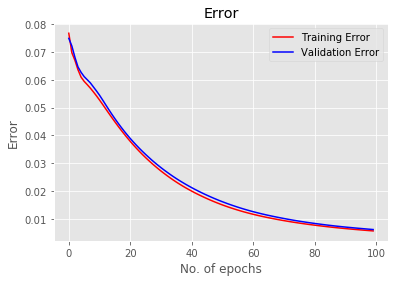

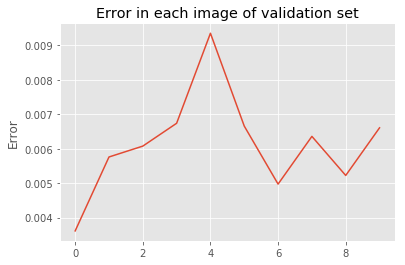

In [118]:
plt.figure(1)
plt.plot(train_graph, color = 'red', label = 'Training Error')
plt.plot(test_graph, color = 'blue', label = 'Validation Error')
plt.title('Error')
plt.xlabel('No. of epochs')
plt.ylabel('Error')
plt.legend()
plt.figure(2)
plt.plot(costs)
plt.title('Error in each image of validation set')
plt.ylabel('Error')

Now lets create a gif of image painting during training.

In [98]:
training = sorted([os.path.join('deepTrain', img) for img in os.listdir('deepTrain') if img.endswith('.png')])

In [99]:
import imageio
images = []
for filename in training:
    images.append(imageio.imread(filename))
imageio.mimsave('training.gif', images, fps = 3)

In [104]:
HTML('<img src = "training.gif">')

Here are some predicted images in validation set.

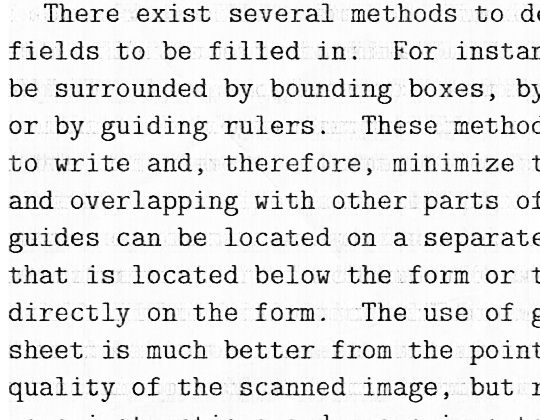

In [116]:
Image(os.path.join('deepValid/deep_net_pred_valid_0.png'))

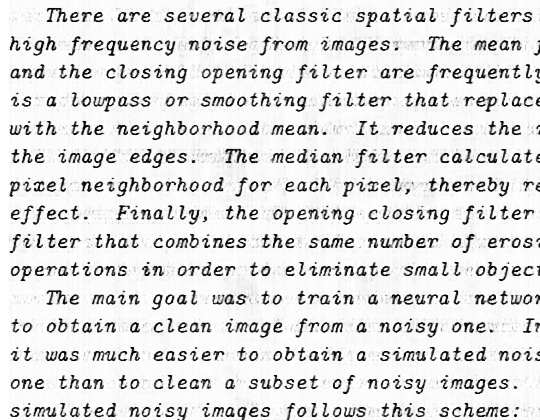

In [117]:
Image(os.path.join('deepValid/deep_net_pred_valid_9.png'))

Given below is some noisy images from training set and the predicted output

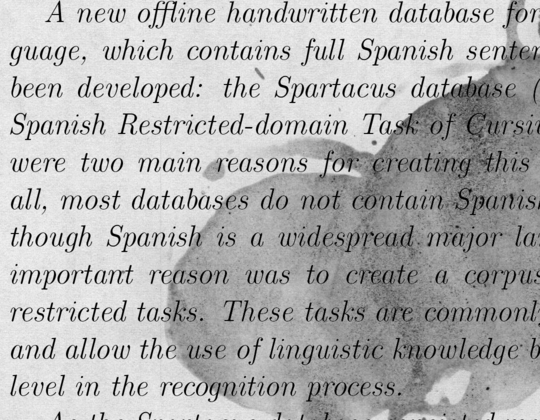

In [109]:
Image(os.path.join('test/73.png'))

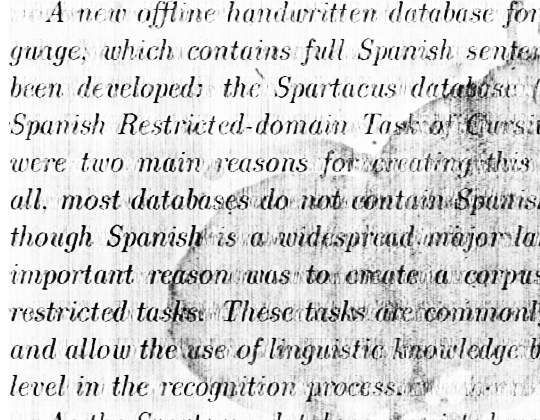

In [106]:
Image(os.path.join('deepTest/deep_net_pred_test_39.png'))

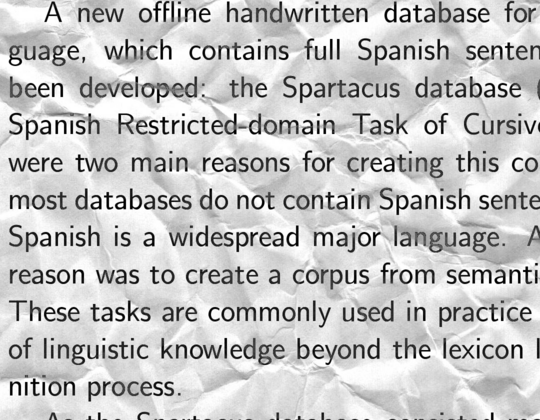

In [110]:
Image(os.path.join('test/118.png'))

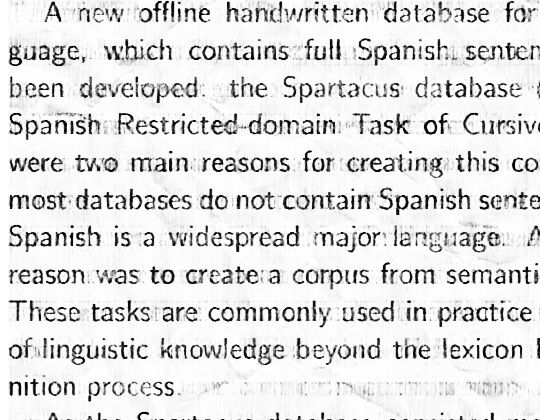

In [111]:
Image(os.path.join('deepTest/deep_net_pred_test_43.png'))

<h2>References</h2>

<p>[1] Parag Mittal, https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow</p>
<p>[2] Junyuan et. al. , Image Denoising and Inpainting with Deep Neural Networks,</p> 